In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [80]:
! pip install torchvision

In [2]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils as vutils
from torchvision.datasets import CIFAR10


In [82]:
device = torch.device("cuda" if True else "cpu")

In [83]:
transform = transforms.Compose([
    transforms.ToTensor(),  
])
train_ds = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_ds  = datasets.CIFAR10(root='./data' ,train=False, transform=transform, download=True)

In [84]:
dataloader=DataLoader(train_ds,batch_size=64,shuffle=True)

In [3]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.net=nn.Sequential(
            nn.Conv2d(3,64,4,2,1),
            nn.LeakyReLU(0.02),
            nn.BatchNorm2d(64),

            nn.Conv2d(64,128,4,2,1),
            nn.LeakyReLU(0.02),
            nn.BatchNorm2d(128),

            nn.Conv2d(128,64,3,1,1),
            nn.LeakyReLU(0.02),
            nn.BatchNorm2d(64)
        )
    def forward(self,i):
        self.x=self.net(i)
        return self.x

In [86]:
class embeddings(nn.Module):
    def __init__(self,num_embeddings,embedding_dim,commitment_cost=0.25):
        super().__init__()
        self.num_embeddings=num_embeddings
        self.embedding_dim=embedding_dim
        self.commitment_cost=commitment_cost

        self.embedding=nn.Embedding(self.num_embeddings,self.embedding_dim)
        self.embedding.weight.data.uniform_(-1/num_embeddings, 1/num_embeddings)

    def forward(self,z):
        b,d,h,w=z.shape
        z_flattened=z.permute(0,2,3,1).contiguous()
        z_flattened=z_flattened.view(-1,d)

        distances = (
            torch.sum(z_flattened**2, dim=1, keepdim=True) +
            torch.sum(self.embedding.weight**2, dim=1) -
            2 * torch.matmul(z_flattened, self.embedding.weight.t())
        )

        indices = torch.argmin(distances, dim=1)
        quantized = self.embedding(indices)
        quantized = quantized.view(b, h, w, d).permute(0, 3, 1, 2).contiguous()

        e_latent_loss = F.mse_loss(quantized.detach(), z)
        q_latent_loss = F.mse_loss(quantized, z.detach())
        loss = q_latent_loss + self.commitment_cost * e_latent_loss

        quantized = z + (quantized - z).detach()

        avg_probs = torch.histc(
            indices.float(), bins=self.num_embeddings, min=0, max=self.num_embeddings-1
        ) / indices.numel()
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
        
        return quantized, indices, loss, perplexity


In [87]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.net=nn.Sequential(
            nn.Conv2d(64,64,3,1,1),
            nn.LeakyReLU(0.02),
            nn.BatchNorm2d(64),

            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),
            nn.LeakyReLU(0.02),
            nn.BatchNorm2d(32),

            nn.ConvTranspose2d(32, 16, 4, stride=2, padding=1),
            nn.LeakyReLU(0.02),
            nn.BatchNorm2d(16),

            nn.Conv2d(16, 3, 3, stride=1, padding=1),
            nn.Tanh()
       )

    def forward(self,x):
        return self.net(x)

In [88]:
class Model(nn.Module):
    def __init__(self, Encoder, Codebook, Decoder):
        super().__init__()
        self.encoder = Encoder
        self.codebook = Codebook
        self.decoder = Decoder
        
    def forward(self,x):
        z=self.encoder(x)
        quantized, indices, loss, perplexity=self.codebook(z)
        x_hat = self.decoder(quantized)
        return x_hat,loss,perplexity


In [89]:
encoder=Encoder()
codebook=embeddings(512,64)
decoder=Decoder()
model=Model(encoder,codebook,decoder).to(device)


In [90]:
from torch.optim import Adam

mse_loss = nn.MSELoss()

optimizer = Adam(model.parameters(), lr=2e-4)


In [91]:
for epoch in range(50):
    overall_loss = 0.0
    for batch_idx, (x, _) in enumerate(dataloader):
        x = x.to(device)

        optimizer.zero_grad()

        x_hat, c_loss, perplexity = model(x)
        recon_loss = mse_loss(x_hat, x)
        
        loss = recon_loss + c_loss
                
        loss.backward()
        optimizer.step()    

        overall_loss += loss.item()  

    avg_loss = overall_loss / len(dataloader)  
    print(f"Epoch [{epoch+1}/50], Loss: {avg_loss:.4f}")

print("Finish!!")


Epoch [1/50], Loss: 1.2445
Epoch [2/50], Loss: 1.0579
Epoch [3/50], Loss: 0.8418
Epoch [4/50], Loss: 0.5890
Epoch [5/50], Loss: 0.3688
Epoch [6/50], Loss: 0.2319
Epoch [7/50], Loss: 0.1589
Epoch [8/50], Loss: 0.1129
Epoch [9/50], Loss: 0.0864
Epoch [10/50], Loss: 0.0710
Epoch [11/50], Loss: 0.0597
Epoch [12/50], Loss: 0.0544
Epoch [13/50], Loss: 0.0517
Epoch [14/50], Loss: 0.0476
Epoch [15/50], Loss: 0.0431
Epoch [16/50], Loss: 0.0395
Epoch [17/50], Loss: 0.0373
Epoch [18/50], Loss: 0.0343
Epoch [19/50], Loss: 0.0325
Epoch [20/50], Loss: 0.0315
Epoch [21/50], Loss: 0.0302
Epoch [22/50], Loss: 0.0289
Epoch [23/50], Loss: 0.0281
Epoch [24/50], Loss: 0.0275
Epoch [25/50], Loss: 0.0267
Epoch [26/50], Loss: 0.0258
Epoch [27/50], Loss: 0.0252
Epoch [28/50], Loss: 0.0249
Epoch [29/50], Loss: 0.0245
Epoch [30/50], Loss: 0.0242
Epoch [31/50], Loss: 0.0238
Epoch [32/50], Loss: 0.0235
Epoch [33/50], Loss: 0.0232
Epoch [34/50], Loss: 0.0230
Epoch [35/50], Loss: 0.0228
Epoch [36/50], Loss: 0.0228
E

In [92]:
import matplotlib.pyplot as plt

In [93]:
def draw_sample_image(x, postfix):
  
    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.title("Visualization of {}".format(postfix))
    plt.imshow(np.transpose(make_grid(x.detach().cpu(), padding=2, normalize=True), (1, 2, 0)))


In [94]:
test_loader=DataLoader(test_ds,batch_size=64,shuffle=True)

In [95]:
from torchvision.utils import save_image, make_grid

In [96]:
model.eval()

with torch.no_grad():

    for batch_idx, (x, _) in enumerate((test_loader)):

        x = x.to(device)
        x_hat, loss, perplexity = model(x)
        break


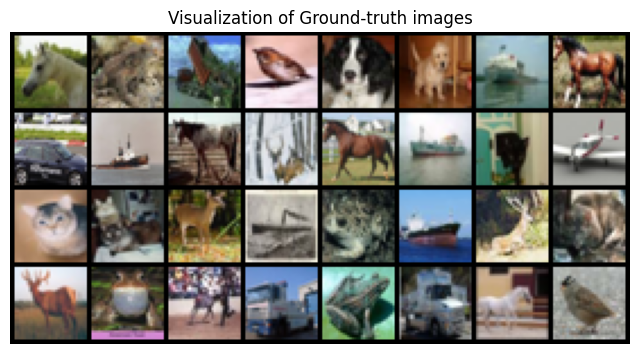

In [97]:
draw_sample_image(x[:64//2], "Ground-truth images")


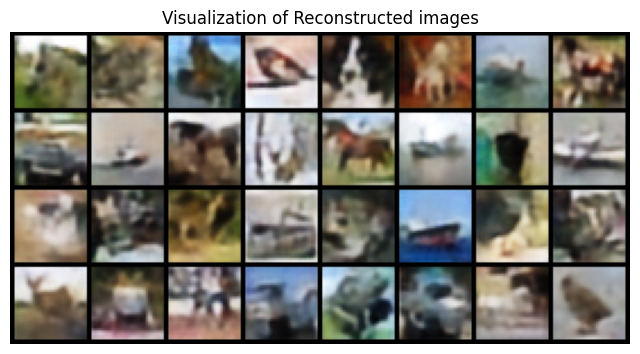

In [98]:
draw_sample_image(x_hat[:64//2], "Reconstructed images")
